In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import Dataset, DataLoader
import joblib
import numpy as np
import cv2
from PIL import Image
import os
from torch import tensor
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

In [4]:
from torchvision.models.segmentation import deeplabv3_resnet50
import torch

num_classes = 5  # 체크포인트 학습 시 클래스 수와 동일하게

# pretrained=False로 새로 모델 생성, num_classes 지정
model = deeplabv3_resnet50(pretrained=False, num_classes=num_classes)

# 모델을 cpu로 이동
model = model.to('cpu')

# strict=False로 파라미터 일부 무시하며 로드
state_dict = torch.load('../Models/Best_model.pth', map_location='cpu')
model.load_state_dict(state_dict, strict=False)

model.eval()

c:\Users\human-02\AppData\Local\anaconda3\envs\FirstProject\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\human-02\AppData\Local\anaconda3\envs\FirstProject\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

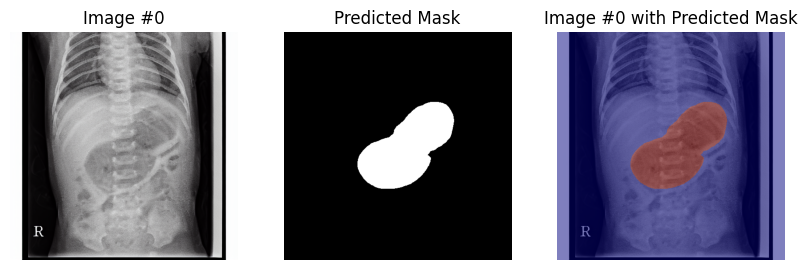

<Figure size 640x480 with 0 Axes>

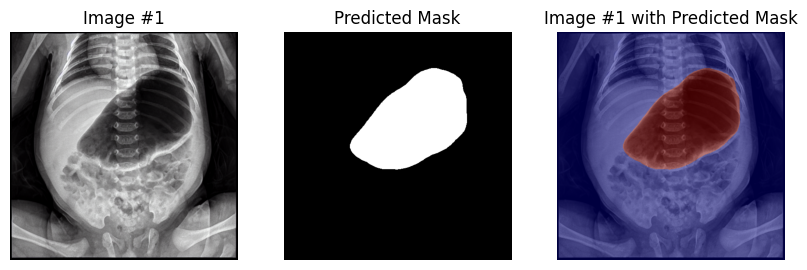

<Figure size 640x480 with 0 Axes>

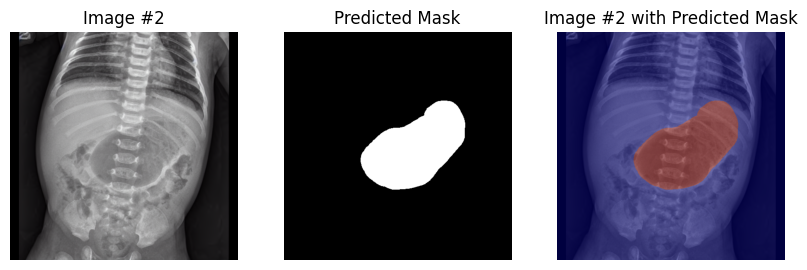

<Figure size 640x480 with 0 Axes>

In [6]:
class Validation_CustomDataset(Dataset):
    def __init__(self,dataframe):
        self.data = joblib.load(dataframe)
        self.W = 512
        self.H = 512
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = os.path.join(row['ImageFile'])
        image = Image.open(image_path).convert('RGB')
        transform = transforms.ToTensor()
        image_tensor = transform(image)
        
        return image_tensor
    
valid_CustomDataset = Validation_CustomDataset('../Dataset/Validation_Data.pkl')    
ValidationLoader = DataLoader(valid_CustomDataset, batch_size=1, shuffle=False)

for idx,image_tensor in enumerate(ValidationLoader):
    with torch.no_grad():
        image = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)
        output = model(image_tensor.to('cpu'))['out']
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        
        # 시각화
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"Image #{idx}")
        plt.axis(False)
        
        plt.subplot(1, 3, 2)
        plt.imshow(pred, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis(False)
        
        plt.subplot(1, 3, 3)
        plt.imshow(image)  # 원본 이미지
        plt.imshow(pred, cmap='jet', alpha=0.5)  # 예측 마스크 (반투명하게)
        plt.title(f"Image #{idx} with Predicted Mask")
        plt.axis('off')
        plt.show()
        
        plt.tight_layout()
        plt.show()

        # 사용자 입력 대기 (Enter 눌러야 다음 이미지로 넘어감)
        inputs = input("Press Enter to show next image...")
        if inputs == 'end':
            break